Гопиенко Александр
КИ22-17/2Б
Практическая работа №3 по машинному обучению
Задание №1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

Выполним проверку на наличие пропусков в датафрейме

In [2]:
df = pd.read_csv("telecom_churn.csv")
missing_values = df.isnull().sum()
print(missing_values)

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64


Выполним кодирование категориальных признаков

In [3]:
df['Churn'] = df['Churn'].astype(int)
encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_features = df.select_dtypes(include=['object']).columns
encoded_features = encoder.fit_transform(df[categorical_features])
df_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
df = pd.concat([df, df_encoded], axis=1)
df.drop(categorical_features, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 69 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account length          3333 non-null   int64  
 1   Area code               3333 non-null   int64  
 2   Number vmail messages   3333 non-null   int64  
 3   Total day minutes       3333 non-null   float64
 4   Total day calls         3333 non-null   int64  
 5   Total day charge        3333 non-null   float64
 6   Total eve minutes       3333 non-null   float64
 7   Total eve calls         3333 non-null   int64  
 8   Total eve charge        3333 non-null   float64
 9   Total night minutes     3333 non-null   float64
 10  Total night calls       3333 non-null   int64  
 11  Total night charge      3333 non-null   float64
 12  Total intl minutes      3333 non-null   float64
 13  Total intl calls        3333 non-null   int64  
 14  Total intl charge       3333 non-null   

Выполним проверку на наличие выбросов с помощью межквартильных интервалов

In [4]:
def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (column < lower_bound) | (column > upper_bound)
    return outliers

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        outliers = detect_outliers(df[column])
        print(f"Количество выбросов в столбце '{column}': {outliers.sum()} ({round((outliers.sum() /df[column].size), 2)})")
        

Количество выбросов в столбце 'Account length': 18 (0.01)
Количество выбросов в столбце 'Area code': 0 (0.0)
Количество выбросов в столбце 'Number vmail messages': 1 (0.0)
Количество выбросов в столбце 'Total day minutes': 25 (0.01)
Количество выбросов в столбце 'Total day calls': 23 (0.01)
Количество выбросов в столбце 'Total day charge': 25 (0.01)
Количество выбросов в столбце 'Total eve minutes': 24 (0.01)
Количество выбросов в столбце 'Total eve calls': 20 (0.01)
Количество выбросов в столбце 'Total eve charge': 24 (0.01)
Количество выбросов в столбце 'Total night minutes': 30 (0.01)
Количество выбросов в столбце 'Total night calls': 22 (0.01)
Количество выбросов в столбце 'Total night charge': 30 (0.01)
Количество выбросов в столбце 'Total intl minutes': 46 (0.01)
Количество выбросов в столбце 'Total intl calls': 78 (0.02)
Количество выбросов в столбце 'Total intl charge': 49 (0.01)
Количество выбросов в столбце 'Customer service calls': 267 (0.08)
Количество выбросов в столбце 'C

In [0]:
column_to_check = df.iloc[:, :16]
df_res = df.iloc[:, 16:]
Q1 = column_to_check.quantile(0.25)
Q3 = column_to_check.quantile(0.75)

# Рассчитываем межквартильный размах (IQR)
IQR = Q3 - Q1

# Определяем границы для определения выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# Фильтруем строки, удаляя выбросы
column_to_check = column_to_check[(column_to_check >= lower_bound) & (column_to_check <= upper_bound)]
df = pd.concat([column_to_check, df_res], axis=1)

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        outliers = detect_outliers(df[column])
        print(f"Количество выбросов в столбце '{column}': {outliers.sum()} ({round((outliers.sum() /df[column].size), 2)})")

In [6]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)

imputer = KNNImputer()
df_filled = imputer.fit_transform(df)
df = pd.DataFrame(df_filled, columns=df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 69 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account length          3333 non-null   float64
 1   Area code               3333 non-null   float64
 2   Number vmail messages   3333 non-null   float64
 3   Total day minutes       3333 non-null   float64
 4   Total day calls         3333 non-null   float64
 5   Total day charge        3333 non-null   float64
 6   Total eve minutes       3333 non-null   float64
 7   Total eve calls         3333 non-null   float64
 8   Total eve charge        3333 non-null   float64
 9   Total night minutes     3333 non-null   float64
 10  Total night calls       3333 non-null   float64
 11  Total night charge      3333 non-null   float64
 12  Total intl minutes      3333 non-null   float64
 13  Total intl calls        3333 non-null   float64
 14  Total intl charge       3333 non-null   

Выполним стандартизацию данных

In [7]:
columns_except_one = [col for col in df.columns if col != 'Churn']
X = df[columns_except_one]
y = df['Churn']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
df = pd.DataFrame(scaled_data, columns=X.columns)
df = pd.concat([df, y], axis=1)
columns_except_one = [col for col in df.columns if col != 'Churn']
X = df[columns_except_one]
y = df['Churn']

Выполним обучение ML-моделей с помощью кросс-валидации

In [8]:
X = X.to_numpy()
y = y.to_numpy()

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Модель k-ближайших соседей
knn_model = KNeighborsClassifier()

# Обучение KNN модели с использованием кросс-валидации и вычисление значений метрик
knn_accuracy = cross_val_score(knn_model, X_train, y_train, cv=stratified_kfold, scoring='accuracy').mean()
knn_precision = cross_val_score(knn_model, X_train, y_train, cv=stratified_kfold, scoring='precision_macro').mean()
knn_recall = cross_val_score(knn_model, X_train, y_train, cv=stratified_kfold, scoring='recall_macro').mean()
knn_f1 = cross_val_score(knn_model, X_train, y_train, cv=stratified_kfold, scoring='f1_macro').mean()

# Подбор параметров модели по кросс-валидации с использованием GridSearchCV
knn_param_grid = {'n_neighbors': [3, 5, 7, 9]}
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=stratified_kfold)
knn_grid_search.fit(X_train, y_train)

# Вывод значений метрик для KNN
print("KNN:")
print("Accuracy:", knn_accuracy)
print("Precision:", knn_precision)
print("Recall:", knn_recall)
print("F1-score:", knn_f1)

# Вывод лучших параметров для KNN
print("\nBest parameters for KNN:", knn_grid_search.best_params_)

# Логистическая регрессия
logreg_model = LogisticRegression(max_iter=1000)

# Обучение LogReg модели с использованием кросс-валидации и вычисление значений метрик
logreg_accuracy = cross_val_score(logreg_model, X_train, y_train, cv=stratified_kfold, scoring='accuracy').mean()
logreg_precision = cross_val_score(logreg_model, X_train, y_train, cv=stratified_kfold, scoring='precision_macro').mean()
logreg_recall = cross_val_score(logreg_model, X_train, y_train, cv=stratified_kfold, scoring='recall_macro').mean()
logreg_f1 = cross_val_score(logreg_model, X_train, y_train, cv=stratified_kfold, scoring='f1_macro').mean()

# Подбор параметров модели по кросс-валидации с использованием GridSearchCV
logreg_param_grid = {'C': [0.1, 1, 10]}
logreg_grid_search = GridSearchCV(logreg_model, logreg_param_grid, cv=stratified_kfold)
logreg_grid_search.fit(X_train, y_train)

# Вывод значений метрик для логистической регрессии
print("\nLogistic Regression:")
print("Accuracy:", logreg_accuracy)
print("Precision:", logreg_precision)
print("Recall:", logreg_recall)
print("F1-score:", logreg_f1)
print("Best parameters for Logistic Regression:", logreg_grid_search.best_params_)

# Модель опорных векторов (SVM)
svm_model = SVC()

# Обучение SVM модели с использованием кросс-валидации и вычисление значений метрик
svm_accuracy = cross_val_score(svm_model, X_train, y_train, cv=stratified_kfold, scoring='accuracy').mean()
svm_precision = cross_val_score(svm_model, X_train, y_train, cv=stratified_kfold, scoring='precision_macro').mean()
svm_recall = cross_val_score(svm_model, X_train, y_train, cv=stratified_kfold, scoring='recall_macro').mean()
svm_f1 = cross_val_score(svm_model, X_train, y_train, cv=stratified_kfold, scoring='f1_macro').mean()

# Подбор параметров модели по кросс-валидации с использованием GridSearchCV
svm_param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=stratified_kfold)
svm_grid_search.fit(X_train, y_train)

# Вывод значений метрик для SVM
print("\nSupport Vector Machine:")
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1-score:", svm_f1)
print("Best parameters for SVM:", svm_grid_search.best_params_)

KNN:
Accuracy: 0.8544631124790072
Precision: 0.6519728637898603
Recall: 0.5226808691711374
F1-score: 0.5109897697567247

Best parameters for KNN: {'n_neighbors': 7}

Logistic Regression:
Accuracy: 0.8649626522194349
Precision: 0.7449507689991318
Recall: 0.5810474814448096
F1-score: 0.6021892185449603
Best parameters for Logistic Regression: {'C': 10}

Support Vector Machine:
Accuracy: 0.860465459451483
Precision: 0.8405160249550395
Recall: 0.5174256820188525
F1-score: 0.49699784787149304
Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


Сравним полученные результаты по метрикам

In [9]:
models = {
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'Logistic Regression': LogisticRegression(C=10),
    'SVM': SVC(probability=True, C=1, gamma='scale', kernel='rbf')  
}


# Словарь для хранения метрик
metrics = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1-score': f1_score
}

# Обучение моделей и сбор метрик
results = {}
roc_auc_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = {}
    for metric_name, metric_func in metrics.items():
        scores[metric_name] = metric_func(y_test, y_pred)
    results[name] = scores
    
    # Вычисление ROC-AUC
    if hasattr(model, "predict_proba"):  # Проверка, поддерживает ли модель метод predict_proba
        y_pred_proba = model.predict_proba(X_test)[:,1]
        roc_auc_scores[name] = roc_auc_score(y_test, y_pred_proba)

# Вывод метрик для каждой модели
print("Metrics for each model:")
for name, scores in results.items():
    print(name)
    for metric_name, score in scores.items():
        print(f"{metric_name}: {score}")
    print()

# Выбор лучшей модели по наибольшему значению ROC-AUC
best_model = max(roc_auc_scores, key=roc_auc_scores.get)
print(f"Best model based on ROC-AUC: {best_model} (ROC-AUC = {roc_auc_scores[best_model]:.2f})")

Metrics for each model:
KNN
Accuracy: 0.8470764617691154
Precision: 0.42857142857142855
Recall: 0.0297029702970297
F1-score: 0.05555555555555556

Logistic Regression
Accuracy: 0.8545727136431784
Precision: 0.5714285714285714
Recall: 0.15841584158415842
F1-score: 0.24806201550387594

SVM
Accuracy: 0.8575712143928036
Precision: 0.8
Recall: 0.07920792079207921
F1-score: 0.14414414414414414

Best model based on ROC-AUC: SVM (ROC-AUC = 0.80)


Построение ROC-кривой

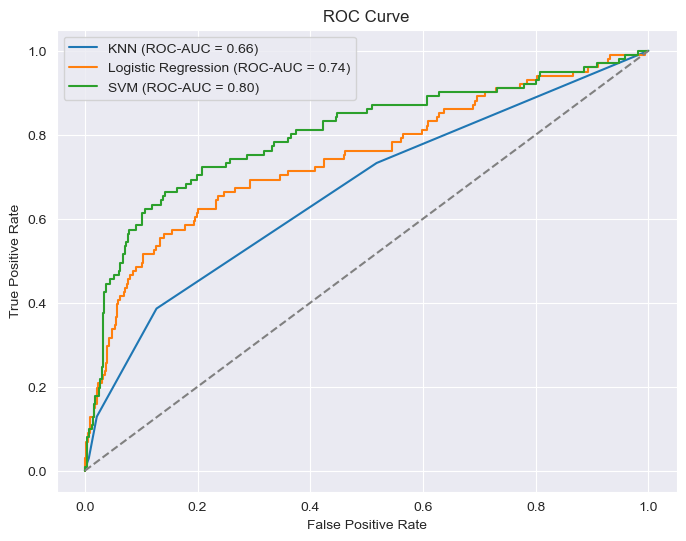

In [10]:
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):  # Проверка, поддерживает ли модель метод predict_proba
        y_pred_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (ROC-AUC = {roc_auc_scores[name]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Визуализация результатов с помощью Confusion Matrix

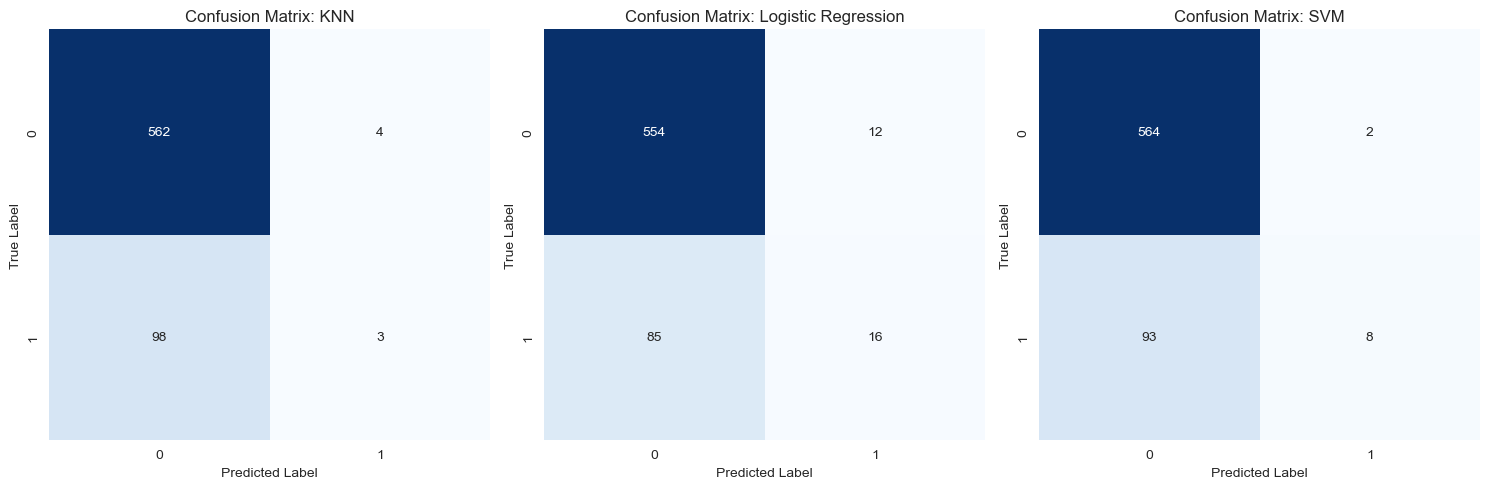

In [11]:
plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(1, len(models), i)
    sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
plt.tight_layout()
plt.show()

Вывод: Научился работать с задачами классификации, применять метрики, кросс-валидацию и GridSearchCV